In [1]:
import pandas as pd
import glob
import os
import time
import numpy as np
from datetime import date, timedelta

# Forecasting time series with complex seasonal patterns
from tbats import TBATS, BATS

# Load mooving average methods
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse,rmse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
import pmdarima                            # for determining ARIMA orders

# Load specific clustering tools
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

from tensorflow.signal import rfft

# Load fbprophet
from fbprophet import Prophet

import matplotlib.pyplot as plt
import math
from datetime import date, timedelta
import dateutil.relativedelta as relativedelta
import holidays

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

#pd.options.plotting.backend = 'matplotlib'
plt.style.use('default')

C:\Users\gianluca.simionato\Programmi\envs\TS\lib\site-packages\tslearn\clustering\kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


In [2]:
wpath = r'C:\Users\gianluca.simionato\Desktop\DS\StreamingDataManagement_TimeSeriesAnalysis\PROJECT'
os.chdir(wpath)

In [3]:
df_orig = pd.read_csv('TrainingSet.csv', sep = ';', decimal = ',')
df_orig['YEAR'] = df_orig['DATA'].str[:4]
df_orig['MONTH'] = df_orig['DATA'].str[5:7]
df_orig['DAY'] = df_orig['DATA'].str[8:]

In [4]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17518 entries, 0 to 17517
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATA    17518 non-null  object
 1   Ora     17518 non-null  int64 
 2   VALORE  17518 non-null  int64 
 3   YEAR    17518 non-null  object
 4   MONTH   17518 non-null  object
 5   DAY     17518 non-null  object
dtypes: int64(2), object(4)
memory usage: 821.3+ KB


In [5]:
df_orig['DATE_TIME'] = pd.to_datetime({'YEAR':df_orig['YEAR'], 'MONTH':df_orig['MONTH'], 'DAY':df_orig['DAY'], 'HOUR':df_orig['Ora']})

In [6]:
df_orig

DATA  Ora   VALORE  YEAR MONTH DAY           DATE_TIME
0      2018-09-01    1  3646742  2018    09  01 2018-09-01 01:00:00
1      2018-09-01    2  3273110  2018    09  01 2018-09-01 02:00:00
2      2018-09-01    3  3069245  2018    09  01 2018-09-01 03:00:00
3      2018-09-01    4  2969621  2018    09  01 2018-09-01 04:00:00
4      2018-09-01    5  2944116  2018    09  01 2018-09-01 05:00:00
...           ...  ...      ...   ...   ...  ..                 ...
17513  2020-08-31   20  4284919  2020    08  31 2020-08-31 20:00:00
17514  2020-08-31   21  4400006  2020    08  31 2020-08-31 21:00:00
17515  2020-08-31   22  3965396  2020    08  31 2020-08-31 22:00:00
17516  2020-08-31   23  3442262  2020    08  31 2020-08-31 23:00:00
17517  2020-08-31   24  2932544  2020    08  31 2020-09-01 00:00:00

[17518 rows x 7 columns]

### Calendario festività

In [7]:
df_orig["Year"] = df_orig['DATE_TIME'].dt.year
df_orig["DATA"] = df_orig['DATE_TIME'].dt.date

In [8]:
year_list = list(df_orig["Year"].unique())
year_list

[2018, 2019, 2020]

In [9]:
holiday_date = []
holiday_name = []
for ptr in holidays.IT(years = year_list, prov='MI').items():
    holiday_date.append(ptr[0])
    holiday_name.append(ptr[1])
df_holiday = pd.DataFrame(list(zip(holiday_date, holiday_name)), columns =['DATA', 'holiday_name'])

In [10]:
df = pd.merge(df_orig, df_holiday, how='left', on='DATA')
df['dummy_holiday'] = np.where(df['holiday_name'] == df['holiday_name'], 1, 0)
df['dummy_Covid'] = np.where(df['DATE_TIME'] > '2020-03-01', 1, 0)

In [11]:
df

DATA  Ora   VALORE  YEAR MONTH DAY           DATE_TIME  Year  \
0      2018-09-01    1  3646742  2018    09  01 2018-09-01 01:00:00  2018   
1      2018-09-01    2  3273110  2018    09  01 2018-09-01 02:00:00  2018   
2      2018-09-01    3  3069245  2018    09  01 2018-09-01 03:00:00  2018   
3      2018-09-01    4  2969621  2018    09  01 2018-09-01 04:00:00  2018   
4      2018-09-01    5  2944116  2018    09  01 2018-09-01 05:00:00  2018   
...           ...  ...      ...   ...   ...  ..                 ...   ...   
17513  2020-08-31   20  4284919  2020    08  31 2020-08-31 20:00:00  2020   
17514  2020-08-31   21  4400006  2020    08  31 2020-08-31 21:00:00  2020   
17515  2020-08-31   22  3965396  2020    08  31 2020-08-31 22:00:00  2020   
17516  2020-08-31   23  3442262  2020    08  31 2020-08-31 23:00:00  2020   
17517  2020-09-01   24  2932544  2020    08  31 2020-09-01 00:00:00  2020   

      holiday_name  dummy_holiday  dummy_Covid  
0              NaN              0            0  
1              NaN              0            0  
2              NaN              0            0  
3              NaN              0            0  
4              NaN              0            0  
...            ...            ...          ...  
17513          NaN              0            1  
17514          NaN              0            1  
17515          NaN              0            1  
17516          NaN              0            1  
17517          NaN              0            1  

[17518 rows x 11 columns]

In [12]:
df = df.loc[:, ['DATE_TIME', 'VALORE', 'dummy_holiday', 'dummy_Covid']]

In [13]:
df.set_index('DATE_TIME', inplace= True)

In [14]:
df = df.resample('H').mean().interpolate('linear')

In [15]:
df

VALORE  dummy_holiday  dummy_Covid
DATE_TIME                                                 
2018-09-01 01:00:00  3646742.0            0.0          0.0
2018-09-01 02:00:00  3273110.0            0.0          0.0
2018-09-01 03:00:00  3069245.0            0.0          0.0
2018-09-01 04:00:00  2969621.0            0.0          0.0
2018-09-01 05:00:00  2944116.0            0.0          0.0
...                        ...            ...          ...
2020-08-31 20:00:00  4284919.0            0.0          1.0
2020-08-31 21:00:00  4400006.0            0.0          1.0
2020-08-31 22:00:00  3965396.0            0.0          1.0
2020-08-31 23:00:00  3442262.0            0.0          1.0
2020-09-01 00:00:00  2932544.0            0.0          1.0

[17544 rows x 3 columns]

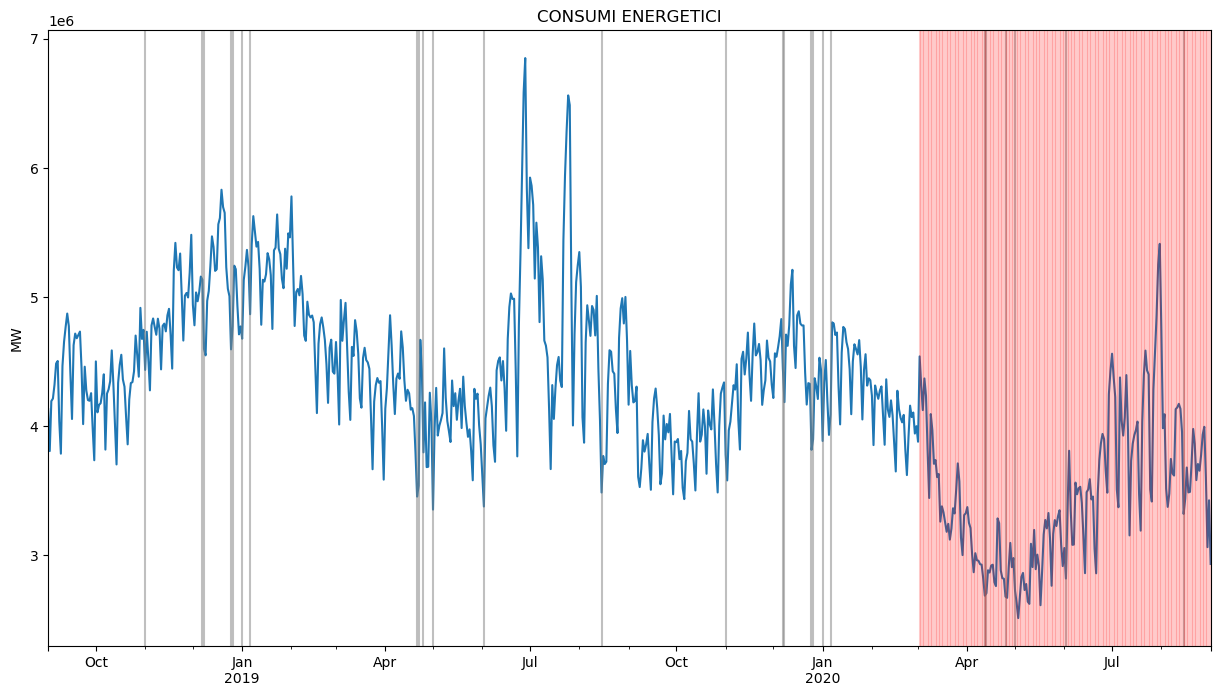

In [16]:
# Plot the forecasted values alongside the original data
title='CONSUMI ENERGETICI'
ylabel='MW'
xlabel='' 
df_1 = df.resample('d').mean()
ax = df_1['VALORE'].plot(legend=False,figsize=(15,8), title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df_1.query('dummy_holiday==1').index: 
    ax.axvline(x=x, color='grey', alpha=0.5)
for x in df_1.query('dummy_Covid==1').index: 
    ax.axvline(x=x, color='r', alpha=0.2)

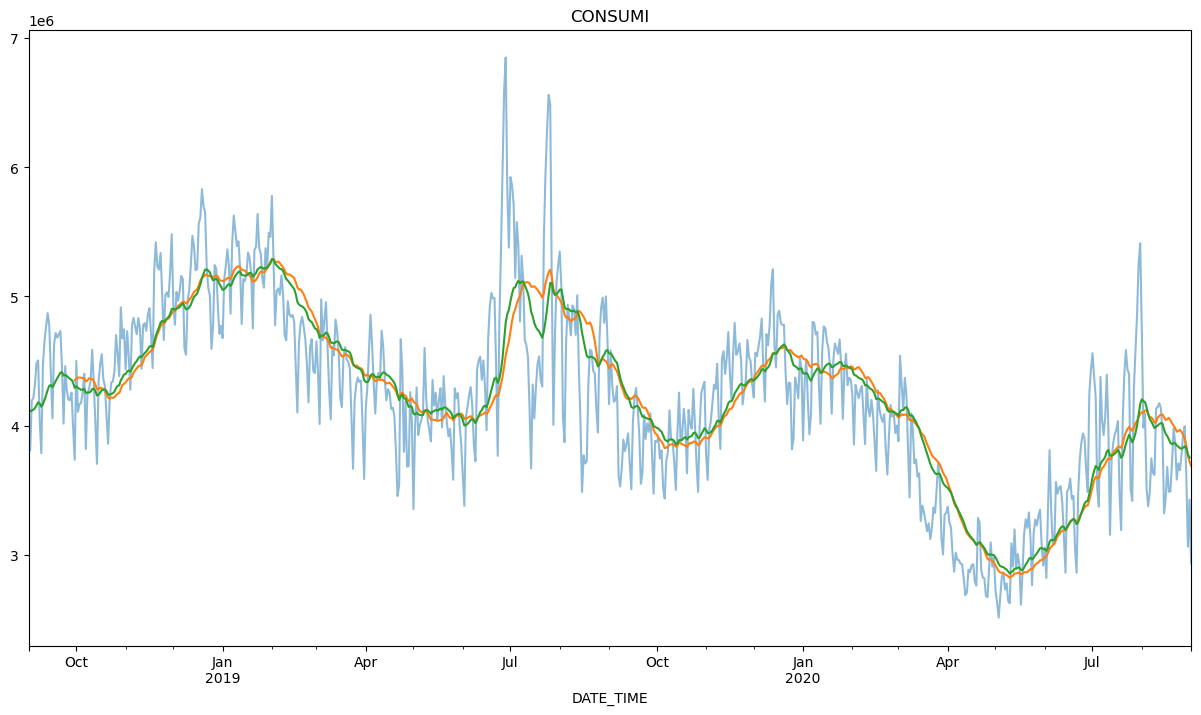

In [17]:

df_1['SMA30'] = df_1['VALORE'].rolling(window = 30).mean()
df_1['SES30'] = SimpleExpSmoothing(df_1['VALORE']).fit(smoothing_level=2/(30+1),optimized=False).fittedvalues.shift(-1)
df_1['VALORE'].plot(figsize=(15,8), alpha=0.5, title = 'CONSUMI').autoscale(axis='x',tight=True )
df_1['SMA30'].plot(figsize=(15,8)).autoscale(axis='x',tight=True)
df_1['SES30'].plot(figsize=(15,8)).autoscale(axis='x',tight=True)

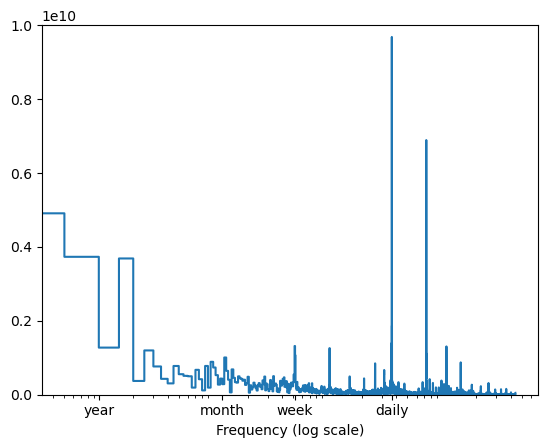

In [87]:
# fourier - frequency
df_f = df[['VALORE']]
fft = rfft(df_f['VALORE'])
f_per_dataset = np.arange(0, len(fft))
n_samples_h = len(df_f['VALORE'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)
f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 1e10)
plt.xticks([1, 12, 52 ,365.2524], labels=['year', 'month', 'week', 'daily'])
_ = plt.xlabel('Frequency (log scale)')

In [88]:
df_f.reset_index(inplace=True)

In [89]:
df_f.columns = ['ds','y']

In [90]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m.add_country_holidays(country_name='IT')
m.fit(df_f)
future = m.make_future_dataframe(periods=24*60, freq='H')
forecast = m.predict(future)

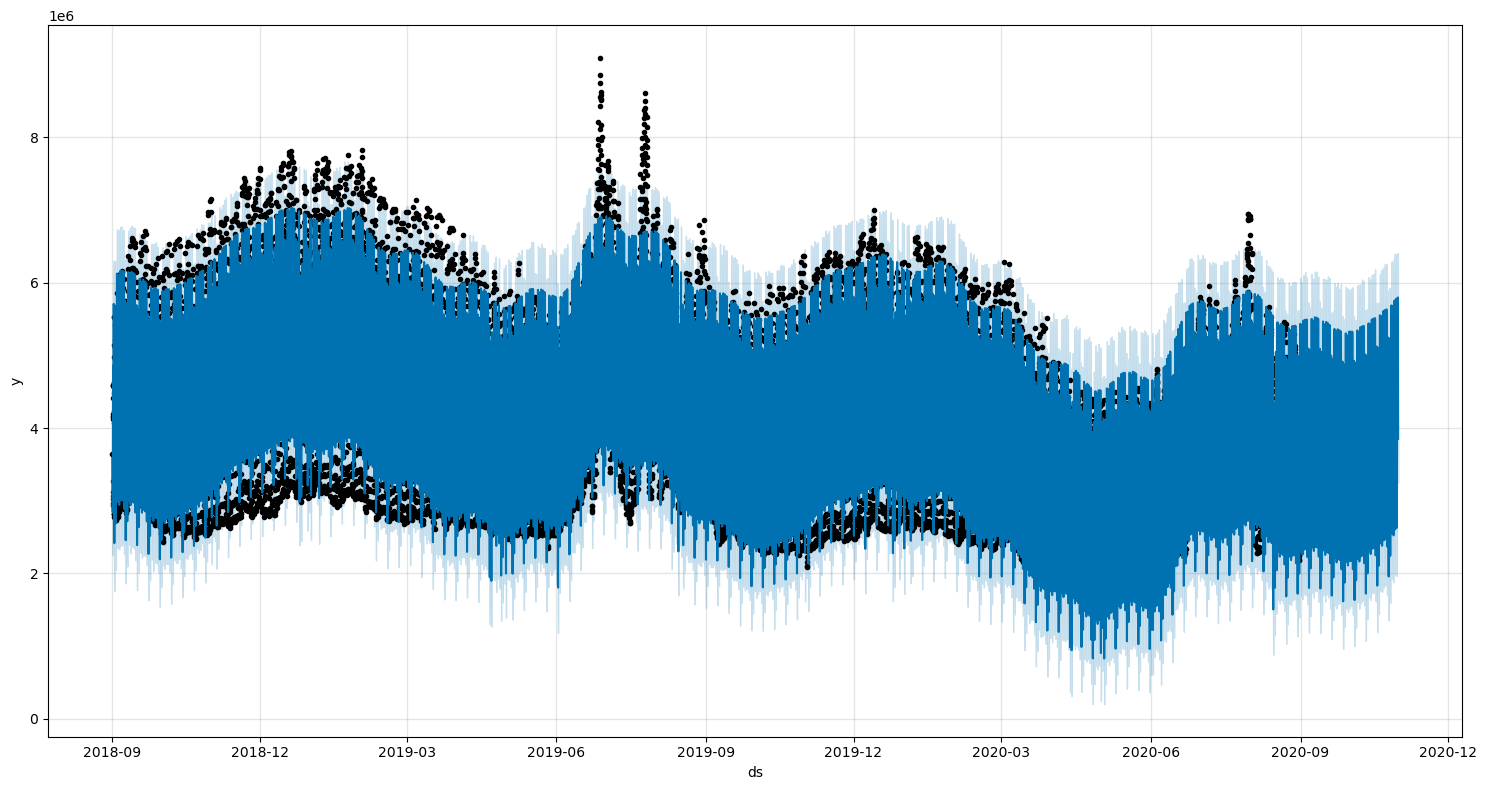

In [91]:
fig1 = m.plot(forecast, figsize=(15,8))

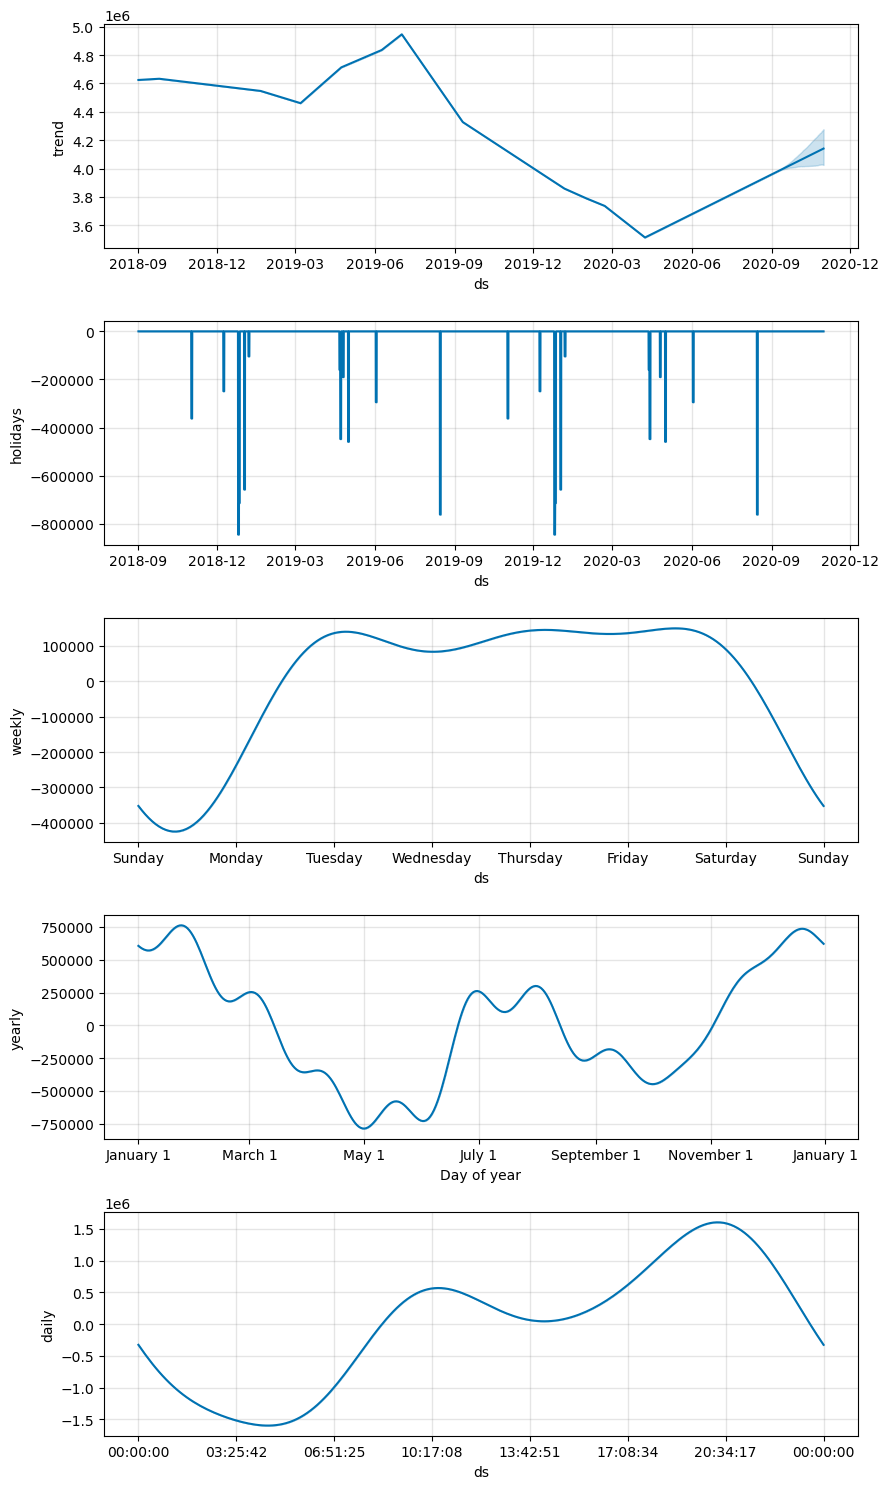

In [92]:
fig2 = m.plot_components(forecast)

In [93]:
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast['ds'] = pd.to_datetime(forecast['ds'], format='%Y-%m-%d')
forecast = forecast.set_index('ds')

In [94]:
forecast

yhat    yhat_lower    yhat_upper
ds                                                           
2018-09-01 01:00:00  3.586692e+06  2.963775e+06  4.189679e+06
2018-09-01 02:00:00  3.216848e+06  2.619623e+06  3.874282e+06
2018-09-01 03:00:00  2.991517e+06  2.394200e+06  3.580535e+06
2018-09-01 04:00:00  2.855582e+06  2.249399e+06  3.439794e+06
2018-09-01 05:00:00  2.838827e+06  2.250273e+06  3.408233e+06
...                           ...           ...           ...
2020-10-30 20:00:00  5.797577e+06  5.143430e+06  6.400951e+06
2020-10-30 21:00:00  5.713079e+06  5.089219e+06  6.408875e+06
2020-10-30 22:00:00  5.266108e+06  4.670999e+06  5.886214e+06
2020-10-30 23:00:00  4.573641e+06  3.881374e+06  5.243806e+06
2020-10-31 00:00:00  3.851981e+06  3.250897e+06  4.467718e+06

[18984 rows x 3 columns]

In [95]:
df_f = df_f.set_index('ds')
forecast.rename(columns = {'yhat' : 'fbProphet Forecast', 'yhat_lower' : 'fbProphet Forecast Lower bound',  'yhat_upper' : 'fbProphet Forecast Upper bound'}, inplace = True)

In [96]:
df_f = pd.merge(df_f, forecast, on='ds' , how='right')

In [97]:
df_f

y  fbProphet Forecast  \
ds                                                   
2018-09-01 01:00:00  3646742.0        3.586692e+06   
2018-09-01 02:00:00  3273110.0        3.216848e+06   
2018-09-01 03:00:00  3069245.0        2.991517e+06   
2018-09-01 04:00:00  2969621.0        2.855582e+06   
2018-09-01 05:00:00  2944116.0        2.838827e+06   
...                        ...                 ...   
2020-10-30 20:00:00        NaN        5.797577e+06   
2020-10-30 21:00:00        NaN        5.713079e+06   
2020-10-30 22:00:00        NaN        5.266108e+06   
2020-10-30 23:00:00        NaN        4.573641e+06   
2020-10-31 00:00:00        NaN        3.851981e+06   

                     fbProphet Forecast Lower bound  \
ds                                                    
2018-09-01 01:00:00                    2.963775e+06   
2018-09-01 02:00:00                    2.619623e+06   
2018-09-01 03:00:00                    2.394200e+06   
2018-09-01 04:00:00                    2.249399e+06   
2018-09-01 05:00:00                    2.250273e+06   
...                                             ...   
2020-10-30 20:00:00                    5.143430e+06   
2020-10-30 21:00:00                    5.089219e+06   
2020-10-30 22:00:00                    4.670999e+06   
2020-10-30 23:00:00                    3.881374e+06   
2020-10-31 00:00:00                    3.250897e+06   

                     fbProphet Forecast Upper bound  
ds                                                   
2018-09-01 01:00:00                    4.189679e+06  
2018-09-01 02:00:00                    3.874282e+06  
2018-09-01 03:00:00                    3.580535e+06  
2018-09-01 04:00:00                    3.439794e+06  
2018-09-01 05:00:00                    3.408233e+06  
...                                             ...  
2020-10-30 20:00:00                    6.400951e+06  
2020-10-30 21:00:00                    6.408875e+06  
2020-10-30 22:00:00                    5.886214e+06  
2020-10-30 23:00:00                    5.243806e+06  
2020-10-31 00:00:00                    4.467718e+06  

[18984 rows x 4 columns]

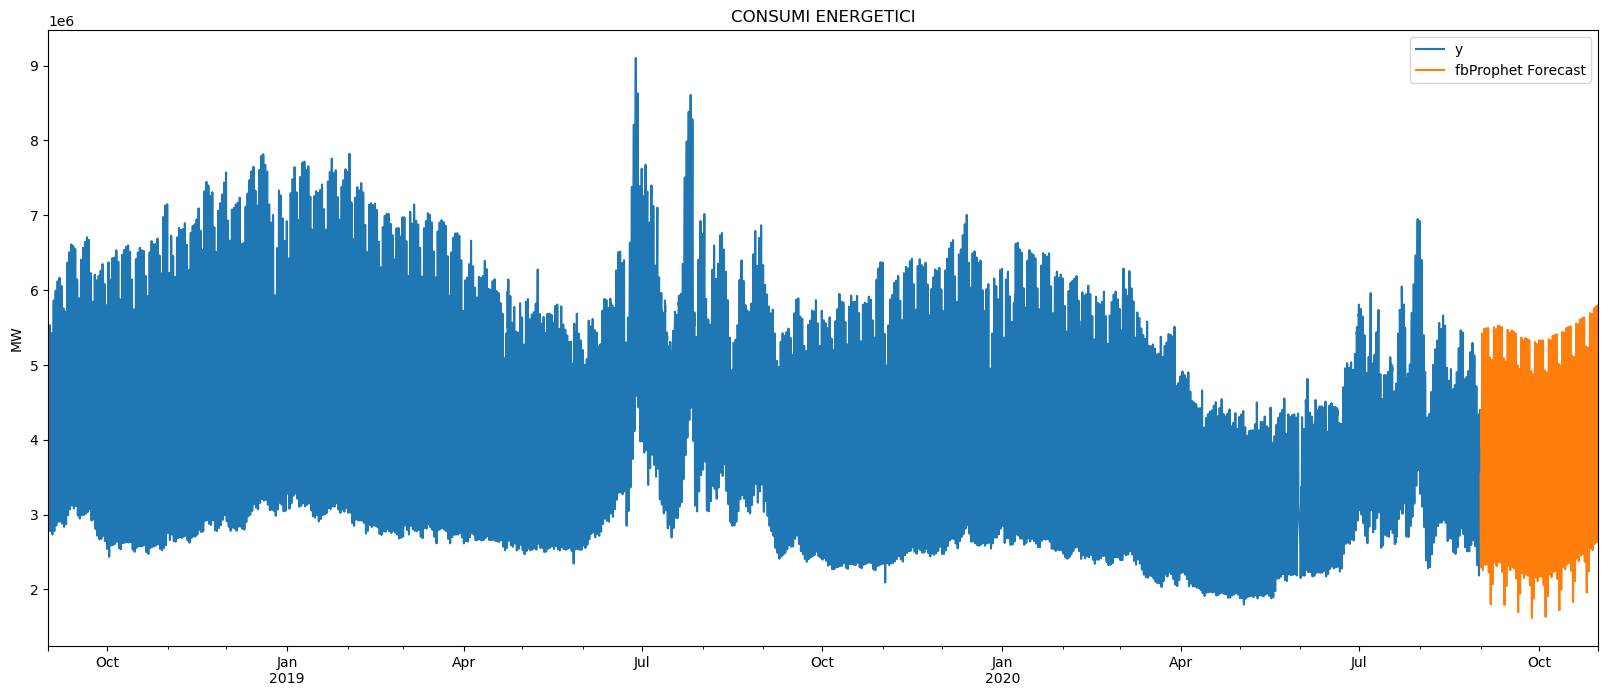

In [98]:
# Plot the forecasted values alongside the original data
title=f'CONSUMI ENERGETICI'
ylabel='MW'
xlabel='' 
forecast1 = forecast.loc['2020-09-01':]
ax = df_f['y'].plot(legend=True,figsize=(20,8),title=title)
forecast1['fbProphet Forecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);